In [2]:
import numpy as np

# Start at 0, end at 100, generate 1000 points
x = np.linspace(0, 100, 1000)
y = np.sin(x)

print(x.shape)
print(y.shape)

(1000,)
(1000,)


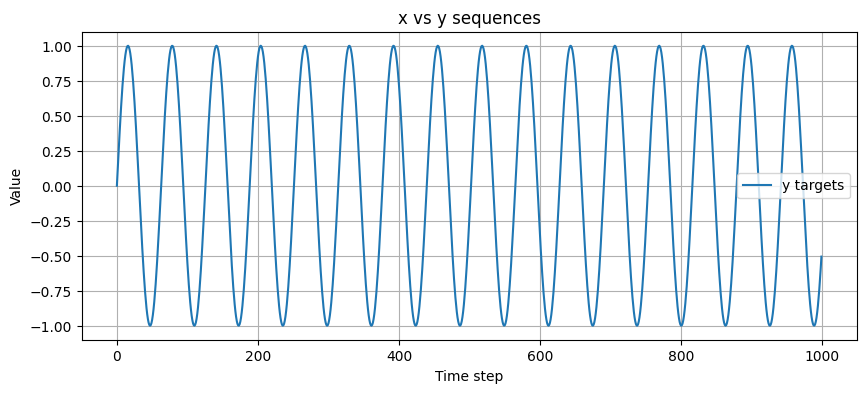

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# x, y can be PyTorch tensors; convert if needed:
x_np = np.asarray(x)
y_np = np.asarray(y)

plt.figure(figsize=(10, 4))
#plt.plot(x_np, label='x inputs')
plt.plot(y_np, label='y targets')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('x vs y sequences')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    
    # We loop until we hit the end of the data minus the window size
    for i in range(len(data) - window_size):
        
        # 1. Input: The sequence from 'i' to 'i + window_size'
        seq = data[ i : i + window_size ] 
        
        # 2. Target: The single value at 'i + window_size'
        label = data[ i + window_size ]
        
        sequences.append(seq)
        targets.append(label)
        
    return np.array(sequences), np.array(targets)

In [10]:
input_seq, target_seq = create_sequences(y, window_size=50)
print("Input sequence shape:", input_seq.shape)
print("Target sequence shape:", target_seq.shape)

Input sequence shape: (950, 50)
Target sequence shape: (950,)


In [11]:
import torch
seqs = torch.from_numpy(input_seq).float()
targets = torch.from_numpy(target_seq).float()

seqs = seqs.unsqueeze(-1)  # Add feature dimension

print("Input sequences tensor shape:", seqs.shape)
print("Target sequences tensor shape:", targets.shape)

Input sequences tensor shape: torch.Size([950, 50, 1])
Target sequences tensor shape: torch.Size([950])


In [19]:
import torch.nn as nn

class SineLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=60, output_size=1):
        super(SineLSTM, self).__init__()
        
        # 1. Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 2. Define the Linear layer (Head)
        self.linear = nn.Linear(60, 1)

    def forward(self, x):
        # 1. Pass data through LSTM
        # out shape: (batch_size, sequence_length, hidden_size)
        out, _ = self.lstm(x)
        
        # 2. Select the hidden state from the LAST time step
        # We want all batches (:), the last time step (-1), and all features (:)
        last_time_step_out = out[:, -1, :]
        
        # 3. Pass that summary to the Linear layer to get the prediction
        prediction = self.linear(last_time_step_out)
        
        return prediction

In [20]:
# 1. Instantiate the model
model = SineLSTM()

# 2. Pass your input data through the model
# Note: This uses the random weights (untrained), so the output values will be garbage.
# We just care about the SHAPE right now.
output = model(seqs)

print("Final Output shape:", output.shape)

Final Output shape: torch.Size([950, 1])


In [27]:
model = SineLSTM()


# 1. Define Loss
criterion = nn.MSELoss()

# 2. Define Optimizer
# We pass it the model's parameters so it knows WHAT to adjust.
# 'lr' is the learning rate (step size). 0.001 is a safe starting point.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. Number of times to loop through the data
epochs = 100

# Set model to training mode (good practice)
model.train()

print("Training started...")

for i in range(epochs):
    
    # --- STEP 1: Forward Pass ---
    # Make predictions for the whole batch
    y_pred = model(seqs)
    
    # --- STEP 2: Calculate Loss ---
    # Compare prediction (y_pred) vs real value (targets)
    loss = criterion(y_pred, targets)
    
    # --- STEP 3: Zero Gradients ---
    # Clear the buffer
    optimizer.zero_grad()
    
    # --- STEP 4: Backward Pass ---
    # Calculate the gradients (backpropagation)
    loss.backward()
    
    # --- STEP 5: Optimizer Step ---
    # Update the weights
    optimizer.step()
    
    # Print progress every 10 epochs
    if i % 10 == 0:
        print(f'Epoch: {i} | Loss: {loss.item():.5f}')

print("Training complete!")

Training started...
Epoch: 0 | Loss: 0.50989
Epoch: 10 | Loss: 0.41776
Epoch: 20 | Loss: 0.29734
Epoch: 30 | Loss: 0.18135
Epoch: 40 | Loss: 0.08766
Epoch: 50 | Loss: 0.01453
Epoch: 60 | Loss: 0.00344
Epoch: 70 | Loss: 0.00336
Epoch: 80 | Loss: 0.00136
Epoch: 90 | Loss: 0.00049
Training complete!


In [28]:
# 1. Re-initialize the Model (Fresh start)
model = SineLSTM()

# 2. Re-initialize the Optimizer (Connect it to the NEW model)
#    Note: I increased the Learning Rate to 0.01 to see results faster
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Define Loss
criterion = nn.MSELoss()

# 4. Fix Target Shape 
# Reshape targets to match predictions: (950) -> (950, 1)
targets = targets.view(-1, 1) 

print("Training started...")

# 5. Training Loop
epochs = 100 # Let's give it a bit more time
for i in range(epochs):
    
    # Forward pass
    y_pred = model(seqs)
    
    # Loss
    loss = criterion(y_pred, targets)
    
    # Zero grad, Backward, Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f'Epoch: {i} | Loss: {loss.item():.5f}')
        
print("Training complete!")

Training started...
Epoch: 0 | Loss: 0.53862
Epoch: 10 | Loss: 0.04720
Epoch: 20 | Loss: 0.00472
Epoch: 30 | Loss: 0.00097
Epoch: 40 | Loss: 0.00018
Epoch: 50 | Loss: 0.00028
Epoch: 60 | Loss: 0.00009
Epoch: 70 | Loss: 0.00004
Epoch: 80 | Loss: 0.00001
Epoch: 90 | Loss: 0.00001
Training complete!


real_signal shape: (950, 1)
predicted_signal shape: (950, 1)
real_signal sample: [[-0.95749253]
 [-0.923873  ]
 [-0.881004  ]
 [-0.8293146 ]
 [-0.76932245]]
predicted_signal sample: [[-0.95813215]
 [-0.92485374]
 [-0.88224566]
 [-0.83072704]
 [-0.77082014]]


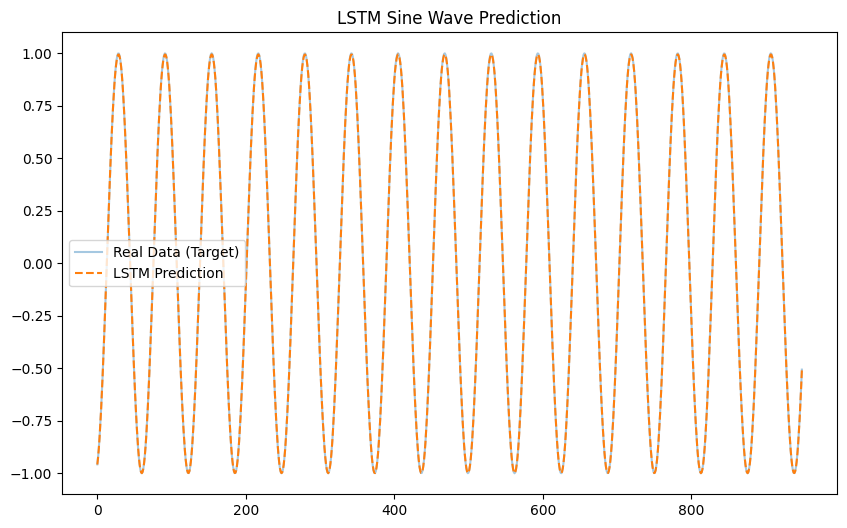

In [34]:
import matplotlib.pyplot as plt

# 1. Set model to evaluation mode (turns off features like Dropout)
model.eval()

# 2. Make predictions on the whole dataset
with torch.no_grad(): # Tells PyTorch "don't calculate gradients", which speeds this up
    predicted_tensor = model(seqs)

# 3. Convert back to NumPy for plotting
# .detach() removes it from the graph, .numpy() converts it
predicted_signal = predicted_tensor.detach().numpy()
real_signal = targets.detach().numpy()
print("real_signal shape:", real_signal.shape)
print("predicted_signal shape:", predicted_signal.shape)
print("real_signal sample:", real_signal[:5])
print("predicted_signal sample:", predicted_signal[:5])
# 4. Plot!
plt.figure(figsize=(10,6))
plt.plot(real_signal, label='Real Data (Target)', alpha=0.4)
plt.plot(predicted_signal, label='LSTM Prediction', linestyle='--')
plt.title('LSTM Sine Wave Prediction')
plt.legend()
plt.show()